In [1]:
import numpy as np
np.set_printoptions(linewidth=1000)

import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate, XGate, ZGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from statevector_to_str import statevector_to_str

In [2]:
kappa = 0.0
delta_t = 1#/2**5

n, m = 1, 2

NX = 4

M_0 = NX
N = [NX]

In [3]:
# Lattice velocities
cxs_unsorted = []
cys_unsorted = []
czs_unsorted = []

idxs_dir = [0, 1]
cxs_unsorted = [1, -1]
cxs = cxs_unsorted
cs = cxs

print(cs)

[1, -1]


In [4]:
n_qubits_lattice = int(np.ceil(np.log2(M_0)))
n_qubits_direction = int(np.ceil(np.log2(m)))
n_qubits_switch = 1
n_qubits_ancilla = 3
n_qubits = 1 + n_qubits_lattice + n_qubits_direction + n_qubits_switch + n_qubits_ancilla

print(f"Total qubits: {n_qubits}")
print(f"Lattice qubits: {n_qubits_lattice}")
print(f"Direction qubits: {n_qubits_direction}")
print(f"Switch qubits: {n_qubits_switch}")
print(f"Ancilla qubits: {n_qubits_ancilla}")

qreg_head = QuantumRegister(1, name="H")
qreg_lattice = QuantumRegister(n_qubits_lattice, name="L")
qreg_direction = QuantumRegister(n_qubits_direction, name="D")
qreg_switch = QuantumRegister(n_qubits_switch, name="S")
qreg_ancilla = QuantumRegister(n_qubits_ancilla, name="A")
creg_measure = ClassicalRegister(n_qubits, name="C")

Total qubits: 8
Lattice qubits: 2
Direction qubits: 1
Switch qubits: 1
Ancilla qubits: 3


In [5]:
M = 2**n_qubits_lattice

print(f"Number of lattice points: {M_0}")
print(f"Next power of 2: {M}")

I_2 = np.eye((2))
I_M = np.eye((M))
I_2M = np.kron(I_2, I_M)
I_4M = np.kron(I_2, I_2M)
Z_2M = np.zeros_like(I_2M)

coordinate_max = M
coordinate_max_bin = bin(coordinate_max-1)[2:]

m_max_bin = bin(m-1)[2:]

print(int(coordinate_max_bin, 2), len(coordinate_max_bin), int(m_max_bin, 2), len(m_max_bin))

Number of lattice points: 4
Next power of 2: 4
3 2 1 1


In [6]:
idx_coord_map = {}

c = 0
for x in range(NX):
    idx_coord_map[bin(c)[2:].zfill(len(coordinate_max_bin))] = x
    # idx_coord_map[bin(c)[2:].zfill(len(coordinate_max_bin))[::-1]] = x
    c += 1

coord_idx_map = dict(zip(idx_coord_map.values(), idx_coord_map.keys()))

print(idx_coord_map)
print("---")
print(coord_idx_map)

{'00': 0, '01': 1, '10': 2, '11': 3}
---
{0: '00', 1: '01', 2: '10', 3: '11'}


In [7]:
# initial statevector preparation
def state_preparation_1d(I_i, S_i):
    initial_statevector = np.zeros((2**n_qubits))

    anc_bin = "000"

    for coordinate_i in range(coordinate_max):
        coordinate_bin = coord_idx_map[coordinate_i][::-1]

        for mu in range(m):
            # @TODO - decide whether or not to reverse the direction string based on
            #         whether unidirectional radiation travels along the correct direction
            mu_bin = bin(mu)[2:].zfill(len(m_max_bin))#[::-1]
        
            for s_bin in range(2):
                if s_bin == 0:
                    prob_amp = I_i[coordinate_i, mu]
                else:
                    prob_amp = 0.5 * delta_t * S_i[coordinate_i, mu]
                
                idx_bin = f"0b{anc_bin}{s_bin}{mu_bin}{coordinate_bin}0"
                idx_dec = int(idx_bin, 2)
                initial_statevector[idx_dec] = prob_amp

    initial_statevector /= np.linalg.norm(initial_statevector)

    qc = QuantumCircuit(qreg_head, qreg_lattice, qreg_direction, qreg_switch, qreg_ancilla)
    qc.initialize(initial_statevector)

    return qc

In [8]:
# absorption and scattering operation
def absorption_scattering_1d():
    # Original matrix
    A = (1 - kappa * delta_t) * I_2

    # LCU method
    a = 1 - kappa * delta_t
    b = 2 * np.sqrt(1 - a**2)
    
    C_1 = np.array([
        [a + 0.5j * b, 0],
        [0, a + 0.5j * b]
    ])
    
    C_2 = np.array([
        [a - 0.5j * b, 0],
        [0, a - 0.5j * b]
    ])

    # Check that LCU method recovers the original matrix
    assert np.sum(A - 0.5*(C_1 + C_2)) == 0j

    # Construct quantum operations
    C_1_gate = UnitaryGate(C_1, label="$C_1$").control(2)
    C_2_gate = UnitaryGate(C_2, label="$C_2$").control(2)

    # Perform quantum circuit composition steps
    qc = QuantumCircuit(qreg_direction, qreg_switch, qreg_ancilla)

    qc.h(qreg_ancilla[0])

    for q in range(n_qubits_direction):
        qc.x(qreg_switch[:])
        
        qc.x(qreg_ancilla[0])
        qc.append(C_1_gate, [qreg_ancilla[0]] + qreg_switch[:] + [qreg_direction[q]])
        qc.x(qreg_ancilla[0])

        qc.append(C_2_gate, [qreg_ancilla[0]] + qreg_switch[:] + [qreg_direction[q]])
        qc.x(qreg_switch[:])

    qc.h(qreg_ancilla[0])

    return qc

In [9]:
# absorption and emission operation
def absorption_emission_1d():
    # Original matrix
    B = np.block([
        [I_2M, I_2M],
        [Z_2M, I_2M]
    ])

    # LCU method
    # D_1 = I_2
    # D_2 = XGate().to_matrix()
    # D_3 = ZGate().to_matrix() @ XGate().to_matrix()
    D_1 = XGate()
    D_2 = XGate()
    D_3 = ZGate()

    # Check that LCU method recovers the original matrix
    assert np.sum(B - np.kron((D_1.to_matrix() + 0.5 * D_2.to_matrix() + 0.5 * D_3.to_matrix()), I_2M)) == 0j

    # Construct quantum operations
    D_1_gate = XGate().control(2) #UnitaryGate(D_1, label="$D_1$").control(2)
    D_2_gate = XGate().control(2) #UnitaryGate(D_2, label="$D_2$").control(2)
    D_3_gate = ZGate().control(2) #UnitaryGate(D_3, label="$D_3$").control(2)

    # Perform quantum circuit composition steps
    qc = QuantumCircuit(qreg_switch, qreg_ancilla)

    qc.h(qreg_ancilla[1])
    qc.h(qreg_ancilla[2])
    
    qc.x(qreg_ancilla[2])
    qc.append(D_1_gate, qreg_ancilla[1:3] + qreg_switch[:])
    qc.x(qreg_ancilla[2])
    
    qc.append(D_2_gate, qreg_ancilla[1:3] + qreg_switch[:])

    qc.append(D_3_gate, qreg_ancilla[1:3] + qreg_switch[:])

    qc.h(qreg_ancilla[1])
    qc.h(qreg_ancilla[2])

    return qc

In [10]:
def propagation_1d():
    # Prepare quantum circuit first since we need to construct it on the fly
    qc = QuantumCircuit(qreg_lattice, qreg_direction, qreg_switch)

    for mu in range(m):
        # Original matrix
        P_mu = np.zeros((M, M))
        
        c_mu = cs[mu]

        mu_bin = bin(mu)[2:].zfill(len(m_max_bin))
        print(mu_bin)

        for idx_init_bin, coord_init in idx_coord_map.items():
            # Periodic BCs
            coord_dest = (coord_init + c_mu) % N[0]
            idx_dest_bin = coord_idx_map[coord_dest]
            
            idx_init_dec = int(f"0b{idx_init_bin[::-1]}", 2)
            idx_dest_dec = int(f"0b{idx_dest_bin[::-1]}", 2)

            # print(coord_init, coord_dest)
            # print(idx_init_bin, idx_dest_bin)
            # print(idx_init_dec, idx_dest_dec)

            P_mu[idx_init_dec, idx_dest_dec] = 1

        ctrl_switch = "0"
        ctrl_direction = mu_bin#[::-1]
        ctrl_state = ctrl_direction + ctrl_switch
    
        P_mu_gate = UnitaryGate(P_mu, label="$P_\\mu$").control(n_qubits_direction + n_qubits_switch, ctrl_state=ctrl_state)

        qc.append(P_mu_gate, qreg_switch[:] + qreg_direction[:] + qreg_lattice[:])

    return qc

In [11]:
# initial intensities (not including sources)
I_i = np.zeros(shape=(M, m))
# I_i[int(coord_idx_map[0], 2), :] = 1

# initial sources
S_i = np.zeros(shape=(M, m))
S_i[int(coord_idx_map[0], 2), 1] = 1

In [12]:
SPCircuit = state_preparation_1d(I_i, S_i)
ASCircuit = absorption_scattering_1d()
AECircuit = absorption_emission_1d()
PCircuit = propagation_1d()

0
1


In [13]:
print("Initial statevector:")
Statevector(SPCircuit).draw("latex")

Initial statevector:


<IPython.core.display.Latex object>

In [14]:
qreg_head = QuantumRegister(1, name="H")

it=0:
Statevector: |00011000〉
it=1:
Statevector: 0.50|00001000〉 + 0.50|00011000〉 + -0.50|01001000〉 + 0.50|01011000〉
it=2:
Statevector: 0.50|00011000〉 + 0.50|01011000〉 + 0.50|10011000〉 + -0.50|11011000〉


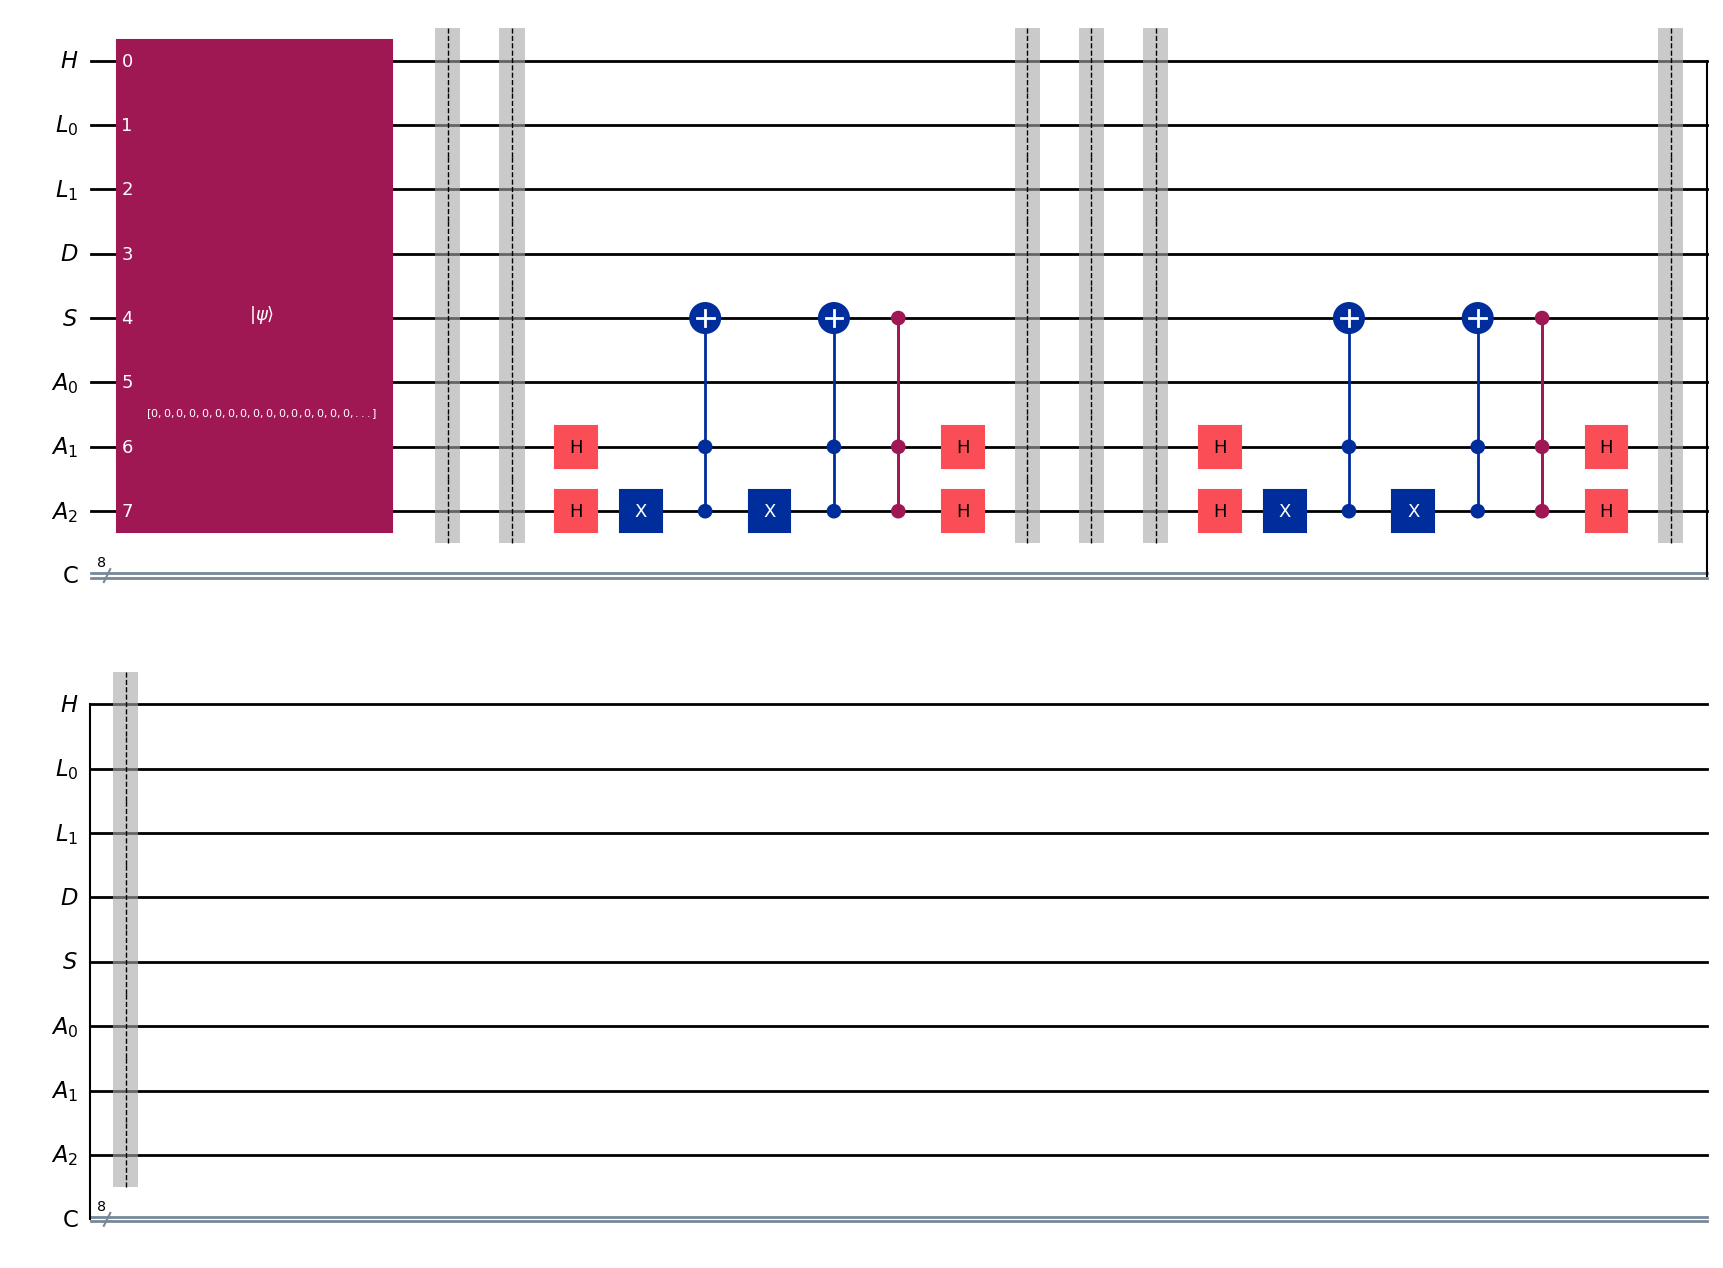

In [15]:
qc = QuantumCircuit(qreg_head, qreg_lattice, qreg_direction, qreg_switch, qreg_ancilla, creg_measure)

qc = qc.compose(SPCircuit, qreg_head[:] + qreg_lattice[:] + qreg_direction[:] + qreg_switch[:] + qreg_ancilla[:])
qc.barrier()

# qc.x(qreg_head)
# qc.barrier()

n_it = 2
for it in range(n_it+1):
    print(f"it={it}:")

    if it > 0:
        # qc = qc.compose(ASCircuit, qreg_direction[:] + qreg_switch[:] + qreg_ancilla[:])
        qc.barrier()
        qc = qc.compose(AECircuit, qreg_switch[:] + qreg_ancilla[:])
        qc.barrier()
        # qc = qc.compose(PCircuit, qreg_lattice[:] + qreg_direction[:] + qreg_switch[:])
        qc.barrier()
    
    sv_array = np.array(Statevector(qc))
    sv_txt = statevector_to_str(sv_array)
    print("Statevector:", sv_txt)

qc.draw(output="mpl")
# qc.decompose(reps=1).draw(output="mpl")

In [16]:
print(list(qc.count_ops().items()))
print(f"Width: {qc.width()}, Depth: {qc.depth()}")

[('h', 8), ('barrier', 7), ('x', 4), ('ccx', 4), ('ccz', 2), ('initialize', 1)]
Width: 16, Depth: 15


In [17]:
important_qubits = [n_qubits-qc.qubits.index(qubit)-1 for qubit in qreg_head[:] + qreg_lattice[:]]
unimportant_qubits = [n_qubits-qc.qubits.index(qubit)-1 for qubit in qreg_direction[:] + qreg_switch[:] + qreg_ancilla[:]]
lattice_qubits = [n_qubits-qc.qubits.index(qubit)-1 for qubit in qreg_lattice[:]]
direction_qubits = [n_qubits-qc.qubits.index(qubit)-1 for qubit in qreg_direction[:]]
switch_qubits = [n_qubits-qc.qubits.index(qubit)-1 for qubit in qreg_switch[:]]
ancilla_qubits = [n_qubits-qc.qubits.index(qubit)-1 for qubit in qreg_ancilla[:]]
print(important_qubits)
print(unimportant_qubits)
print(lattice_qubits)
print(direction_qubits)
print(switch_qubits)
print(ancilla_qubits)

[7, 6, 5]
[4, 3, 2, 1, 0]
[6, 5]
[4]
[3]
[2, 1, 0]


In [18]:
sv = Statevector(qc)

print(np.count_nonzero(sv), np.size(sv))
print(sv.dim, sv.num_qubits)
print(sv.purity())

sv.draw("latex")

8 256
256 8
0.999999999999996


<IPython.core.display.Latex object>

In [19]:
sv_subspace = Statevector([1,0]).tensor(Statevector([1,0])).tensor(Statevector([1,0]))
# sv_subspace = Statevector([0,1]).tensor(Statevector([0,1])).tensor(Statevector([0,1]))
# sv_subspace = Statevector([1,0]).tensor(Statevector([1,0])).tensor(Statevector([0,1]))
P_subspace = sv_subspace.to_operator()

sv_proj = sv.evolve(P_subspace, ancilla_qubits)

print(np.count_nonzero(sv_proj), np.size(sv_proj))
print(sv_proj.dim, sv_proj.num_qubits)
print(sv_proj.purity())

sv_proj.draw("latex")

8 256
256 8
0.999999999999996


<IPython.core.display.Latex object>

In [20]:
sv_L = partial_trace(sv_proj, unimportant_qubits)

print(np.count_nonzero(sv_L), np.size(sv_L))
print(sv_L.dim, sv_L.num_qubits)
print(sv_L.purity())

sv_L.draw("latex")

16 64
8 3
(0.999999999999996+0j)


<IPython.core.display.Latex object>

In [21]:
qc_meas = qc.copy()
qc_meas.measure(range(n_qubits), creg_measure)
# qc_meas.draw("mpl")

In [22]:
aer_sim = AerSimulator(method="automatic")
qc_transpiled = transpile(qc_meas, aer_sim, optimization_level=0)
result = aer_sim.run(qc_transpiled, shots=1E4).result()
counts = result.get_counts(qc_transpiled)

counts_post = dict([(measurement, count) for measurement, count in counts.items() if measurement[:3] == "000"])
print(counts)
print(counts_post)

{'11011000': 2467, '10011000': 2521, '00011000': 2530, '01011000': 2482}
{'00011000': 2530}


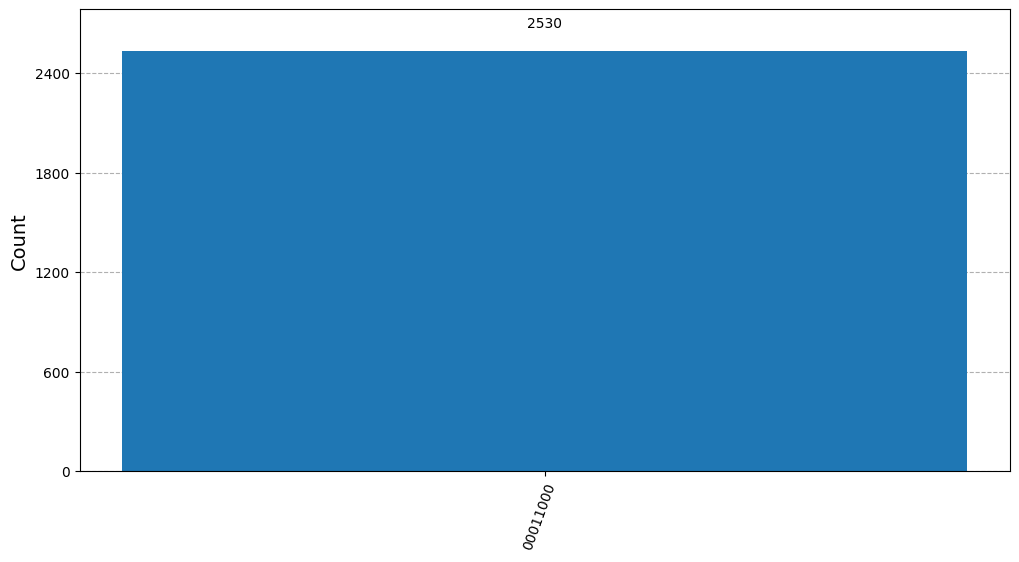

In [23]:
# plot_histogram(counts, figsize=(12,6))
plot_histogram(counts_post, figsize=(12,6))

In [24]:
lattice = np.zeros((NX, m))

print(counts)

for outcome, count in counts.items():
    outcome_ancilla_bin = "".join(outcome[l] for l in ancilla_qubits)
    outcome_switch_bin = "".join(outcome[l] for l in switch_qubits)
    if outcome[:3] == "000" and outcome[switch_qubits[0]] == "0":
        print(outcome)
        lattice_point_bin = "".join(outcome[l] for l in lattice_qubits)
        x = idx_coord_map[lattice_point_bin]

        lattice_direction_bin = "".join(outcome[l] for l in direction_qubits)
        mu = int(lattice_direction_bin, 2)
        
        print(f"{lattice_point_bin} ({x}), {mu}")
        
        lattice[x, mu] += count

print(lattice)

{'11011000': 2467, '10011000': 2521, '00011000': 2530, '01011000': 2482}
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [25]:
x = np.sum(lattice, axis=-1)

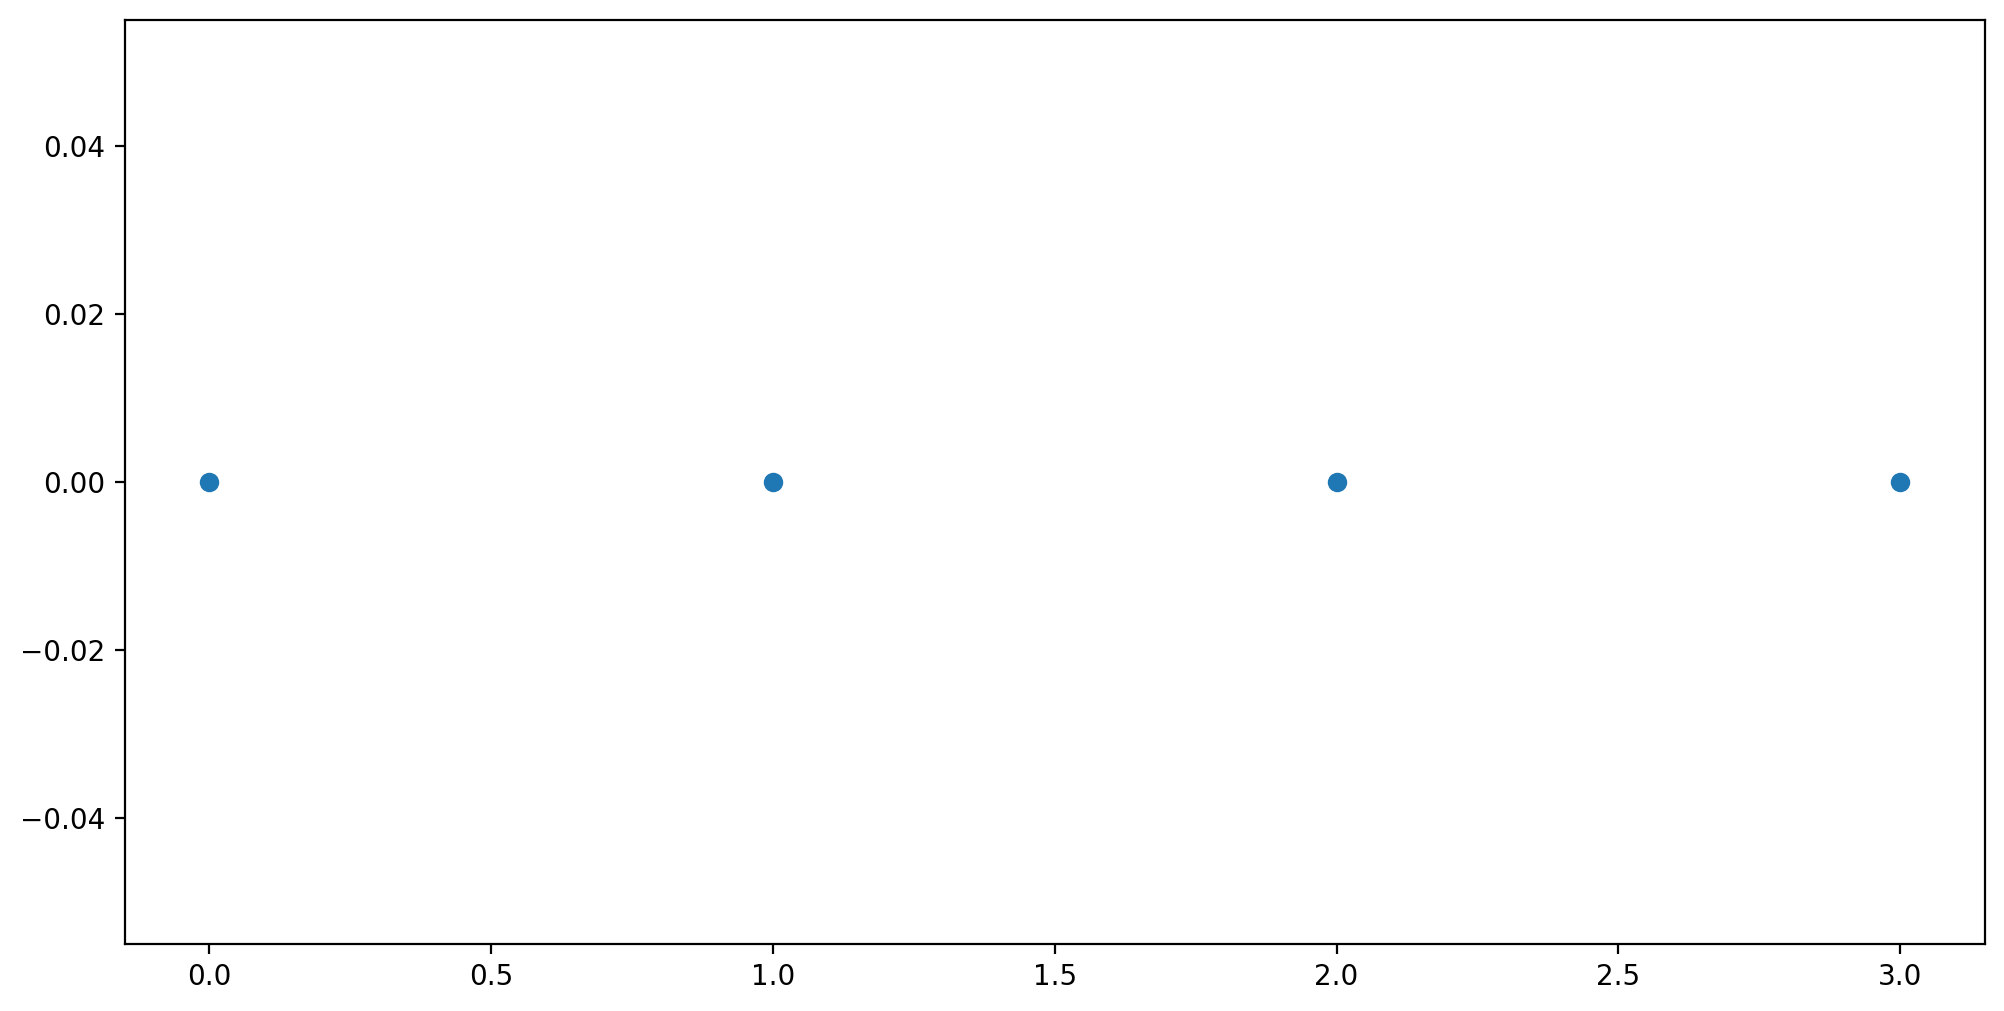

In [26]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

plt.scatter(range(NX), x)

y_min = min(x)
if y_min > 0:
    y_max = max(x)
    plt.ylim(y_min, y_max*1.1)

plt.show()